### Climate skill at 1&deg;

Maps of trend sensitivity to CO$_2$ for `TMP2m` and `air_temperature_0`.

In [1]:
from collections import namedtuple
from string import ascii_lowercase

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from dask.diagnostics import ProgressBar

from utils import get_beaker_dataset_variables, FIGURE_DIR, DPI, FONTSIZE, savefig
from constants import CO2_SENSITIVITY_ACE2_SHiELD_1DEG

In [2]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units"))

EVAL_VARS = [
    EvalVar("TMP2m", "2-meter\nair temperature", "K"),
    EvalVar("air_temperature_0", "layer-0\nair temperature", "K")
]
DS_VARS = [var.name for var in EVAL_VARS] + ['T2m'] # need to add T2m because the no-CO2 model outputs this due to typo

In [3]:
def compute_slope_intercept(prediction, years):
    return np.polyfit(years, prediction, 1)

def compute_decadal_trend(prediction, years, **ufunc_kwargs):
    result = xr.apply_ufunc(
        compute_slope_intercept,
        prediction,
        years,
        input_core_dims=[
            ("year",),
            ("year",),
        ],
        output_core_dims=[
            ("degree",),
        ],
        vectorize=True,
        **ufunc_kwargs
    )
    decadal_trend = 10 * result.isel(degree=0)
    intercept = result.isel(degree=1)
    return decadal_trend, intercept

In [4]:
# download annual- and global-mean time series from beaker

datasets = []
for group_name, group_runs in CO2_SENSITIVITY_ACE2_SHiELD_1DEG.items():
    for ic_name, ic_run in group_runs.items():
        full_key = '/'.join([group_name, ic_name])
        print(f"Getting run: {full_key=} at {ic_run=}")
        ic_dataset = get_beaker_dataset_variables(ic_run, 'monthly_mean_predictions.nc', DS_VARS)
        ic_dataset = ic_dataset.squeeze().isel(time=slice(None, -3)).groupby('valid_time.year').mean()
        # need to rename T2m to TMP2m in some cases
        if 'T2m' in ic_dataset.data_vars:
            ic_dataset = ic_dataset.rename({'T2m': 'TMP2m'})
        dims = {'group': [group_name], 'IC': [ic_name]}
        datasets.append(
            ic_dataset
            .expand_dims(**dims)
        )
annual_ds = xr.merge(datasets)

# set group order
group_order = ['historical-CO2', 'fixed-CO2', 'no-CO2', 'SHiELD-reference']
annual_ds = annual_ds.reindex(group=group_order)

Downloading ⠋ 0:00:15 84.2 MB/s 1.0 GB

In [5]:
# for computing global means
weights = np.cos(np.deg2rad(annual_ds.lat))

# compute spatial maps of decadal trends in each dataset
prediction_trends, _ = compute_decadal_trend(
    annual_ds,
    annual_ds.year,
)

In [6]:
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE)
plt.rc('axes', labelsize=(FONTSIZE - 2))
plt.rc('xtick', labelsize=(FONTSIZE - 4))
plt.rc('ytick', labelsize=(FONTSIZE - 4))
plt.rc('figure', dpi=DPI)

figsize = [1.27 * dim for dim in [5.5, 2.4]] # should be [5.5, 2.4], but need to scale up for unknown font size reasons

def plot_faceted_maps(da_spatial, facets, cbar_label, weights=weights, figsize=figsize, long_name_dim='variable_long_name', **plot_kwargs):
    fg = da_spatial.plot(
        subplot_kws=dict(projection=ccrs.Robinson(central_longitude=180)),
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        figsize=figsize,
        **facets,
        **plot_kwargs
    )
    fig, axes = fg.fig, fg.axs.squeeze()
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            i_panel = i * da_spatial.sizes[facets['col']] + j
            col_indexer = {facets['col']: j}
            row_indexer = {facets['row']: i}
            col_name = da_spatial.isel(**col_indexer)[facets['col']].item()
            global_mean = da_spatial.isel(**col_indexer, **row_indexer).weighted(weights).mean().item()
            ax.set_title(f"{ascii_lowercase[i_panel]}) {col_name.replace('-', ' ')}: {global_mean:0.2f}")
            if ax == ax_row[-1]:
                # need this special logic to dynamically set the right-side "title" labels
                # of xr facetgrid plots, as they are not titles or axis labels but annotations
                children = ax.get_children()
                for child in children:
                    if isinstance(child, plt.Annotation):
                        row_name = da_spatial.isel(**row_indexer)[long_name_dim].item()
                        child.set(x=1.1, text=row_name, fontsize='small', horizontalalignment='center')
    for ax in axes.flatten():
        ax.coastlines(color=[0.5, 0.5, 0.5], lw=0.5)
    cax = fig.add_axes([0.1, 0.025, 0.80, 0.025])
    fig.colorbar(
        fg._mappables[0],
        cax=cax,
        orientation='horizontal',
        label=cbar_label,
        extend='both'
    )
    return fg

/tmp/ipykernel_3540349/3898736515.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fg.fig.tight_layout()


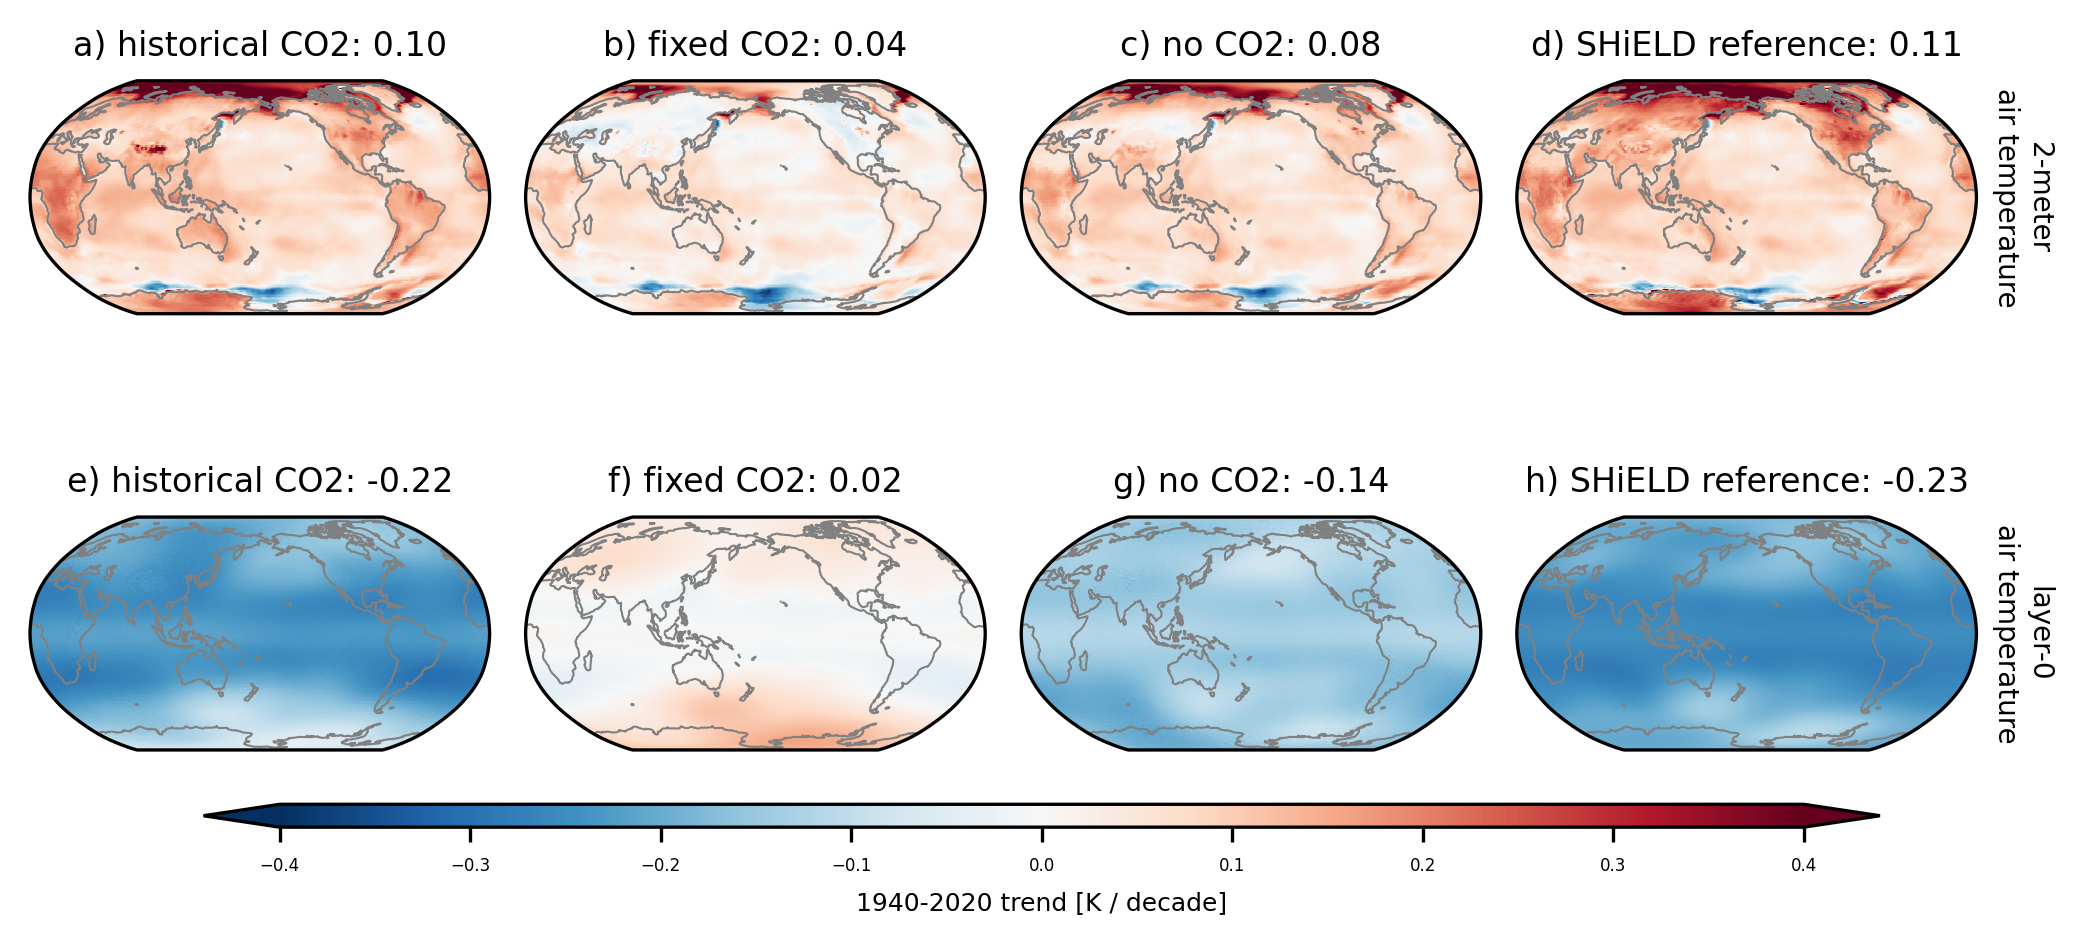

In [7]:
ic_mean_trends = prediction_trends.mean('IC')
ic_mean_trends_allvars = ic_mean_trends.to_array(dim='variable_name', name='variable_name')
ic_mean_trends_allvars = ic_mean_trends_allvars.assign_coords({'variable_long_name': xr.DataArray([var.long_name for var in EVAL_VARS], dims=['variable_name'])})

cbar_label = '1940-2020 trend [K / decade]'
plot_kwargs = dict(vmin=-0.4, vmax=0.4, cmap='RdBu_r')
facets = {'col': 'group', 'row': 'variable_name'}

fg = plot_faceted_maps(ic_mean_trends_allvars, facets, cbar_label, **plot_kwargs)
fg.fig.tight_layout()

savefig(fg.fig, 'climate_skill_1deg_temperature_co2_sensitivity.png')